In [245]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from pylab import rcParams

rcParams['figure.figsize'] = 25, 15

# для построения моделей воспользуемся sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

from sklearn.cluster import  DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import itertools


%matplotlib inline

Цель:

На этот раз займемся классической задачкой - сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомится со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.

Описание/Пошаговая инструкция выполнения домашнего задания:

Часть 1. EDA и Preprocessing.
1.Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;
2.Проведите EDA, чтобы познакомиться с признаками;
3.Преобразуйте все признаки в числовые подходящими методами;
4.Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).
Часть 2. Моделирование.
1.Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;
2.Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости.
Часть 3. Интерпретация.
1.Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
2.Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?


In [246]:
# Функция для скалирования и инвертирования
def make_scale(dataframe, inv=0):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(dataframe)
    if inv == 0:
        return scaled
    elif inv == 1:
        inversed = scaler.inverse_transform(scaled)
        return inversed

In [247]:
# Функция для преобразования РСА
def make_PCA(dataframe, n=2):
    converter_pca = PCA(n_components=n, random_state=42)
    return converter_pca.fit_transform(dataframe)

In [248]:
# Функция для преобразования UMAP
def make_UMAP(dataframe, n=2):
    converter_umap = umap.UMAP(n_components=n,random_state=42)
    return converter_umap.fit_transform(dataframe)

In [249]:
# Функция для преобразования tSNE
def make_TSNE(dataframe, n=2):
    tsne = TSNE(n_components=n, random_state=42, n_jobs=-1)
    return tsne.fit_transform(dataframe)

In [250]:
# функция реализации DBSCAN

def make_DBSCAN_2D(dataframe, epsilon=0.5, min_sam=5):
    dbscan = DBSCAN(eps = epsilon, min_samples = min_sam).fit(dataframe)
    db_labels = dbscan.labels_
    plt.scatter(dataframe[:,0], dataframe[:,1], c=db_labels)

    return plt.show()

In [251]:
# функция для выводя трёхмерных графиков с кластеризацией
def Data_Color(i):

    if (i == -1):
        return "white"

    elif (i == 0):
        return "red"
    elif (i == 1):
        return "blue"
    elif (i == 2):
        return "green"
    elif (i == 3):
        return "orange"
    elif (i == 4):
        return "yellow"
    elif (i == 5):
        return "pink"
    elif (i == 6):
        return "purple"

    else:
        return 'violet'

def make_3D_plot_DBSCAN(dataframe, plot_name='*******', epsilon=0.5, min_sam=5):
    dbscan = DBSCAN(eps = epsilon, min_samples = min_sam).fit(dataframe)
    db_labels = dbscan.labels_

    data = dataframe
    fig = go.Scatter3d(x=data[:, 0],
                       y=data[:, 1],
                       z=data[:, 2],
                       marker=dict(opacity=0.9,
                                   reversescale=True,
                                   color=list(map(Data_Color, db_labels)),
                                   size=4
                                   ),
                       line=dict (width=0.02),
                       mode='markers',

                       )


    layout = go.Layout(scene=dict(  xaxis=dict( title="data[0]"),
                                    yaxis=dict( title="data[1]"),
                                    zaxis=dict(title="data[2]")),
                       title=plot_name
                       )

    fig = go.Figure(data=fig, layout=layout)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    return fig.show()

In [148]:
# функция показывающая метрики гридсёрча, улучшенная версия функции с лекции

def get_scores_and_labels(combinations, dataframe):
    scores = []
    all_labels_list = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan = DBSCAN(eps=eps, min_samples=num_samples).fit(dataframe)
        labels = dbscan.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1

        if (num_clusters < 2) or (num_clusters > 50):
            scores.append(-10)
            all_labels_list.append('bad')
            continue

        scores.append(silhouette_score(dataframe, labels))
        all_labels_list.append(labels)

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_list[best_index]
    best_score = scores[best_index]

    return {'best_epsilon': best_parameters[0],
            'best_min_samples': best_parameters[1],
            'best_labels': best_labels,
            'best_score': best_score}

# 「 Dataset Loading. No need 4 EDA 」

In [10]:
Etalon_no_SA_CA_oh_en_no_risk = pd.read_csv('Etalon_no_SA_CA_oh_en_no_risk.csv')

# 「 Data scaling 」

Скейлинг обязателен для алгоритмов кластеризации, в виду того, что кластеризация основана на расстоянии и нахождении близких друг к другу объектов, а для этого все данные должны быть представленны в ордной размерности, иначе кластеризация получится искажённой и результат будет не верным.

In [12]:
Etalon_no_SA_CA_oh_en_no_risk_scale = make_scale(Etalon_no_SA_CA_oh_en_no_risk)

# 「 Dimensionality Reduction to 2D 」

In [13]:
Etalon_no_SA_CA_oh_en_no_risk_scale_PCA  = make_PCA(Etalon_no_SA_CA_oh_en_no_risk_scale)
Etalon_no_SA_CA_oh_en_no_risk_scale_UMAP = make_UMAP(Etalon_no_SA_CA_oh_en_no_risk_scale)
Etalon_no_SA_CA_oh_en_no_risk_scale_TSNE = make_TSNE(Etalon_no_SA_CA_oh_en_no_risk_scale)

# 「 Часть 2. Моделирование. 」

In [205]:
# создаём ряд эпсилонов
epsilons = np.linspace(0.01, 1.5, num=100)
# epsilons

In [204]:
# создаём список сэмплов
min_samples = np.arange(4, 16, step=1)
# min_samples

In [180]:
combinations = list(itertools.product(epsilons, min_samples))
len(combinations)

1200

In [236]:
best_dict = get_scores_and_labels(combinations, Etalon_no_SA_CA_oh_en_no_risk_scale)

In [237]:
best_dict

{'best_epsilon': 1.5,
 'best_min_samples': 4,
 'best_labels': array([ 0,  7,  1, -1,  2, -1,  3, -1,  4,  5,  6, -1,  7,  8,  6,  9,  0,
        10, -1,  0, 11, 12, 13, 11,  3, 14,  4, -1,  0, -1, 10,  3, 11, -1,
        -1, -1, -1,  0, -1,  0, 15,  0, -1, -1, -1, 16,  0, -1,  8,  7, 14,
         5,  0, 11,  2,  8, -1,  7, 16, 35, 10,  0, -1, -1,  7, -1,  7, 11,
        -1,  7, 17, -1, -1, -1, -1, -1,  0,  0, -1,  3,  7,  0, -1, -1,  4,
        -1, 18, -1,  5, 19,  0, 11,  9, 20, 11, -1, 34, 10,  0, -1, 13, 12,
         7, 20, 21, -1,  5, 11, 18, 10, 10, -1, -1, 17,  0,  0, -1, 22, 18,
         5,  7, -1, -1,  2, 22, 11,  4, 19,  5, 23, 17, 25, 14, -1, -1,  7,
        11,  4,  0, -1, -1, -1, 15,  3, 18, 10, 23, 23,  3,  0, 24,  0,  0,
         6, -1, 22, -1,  1, 11,  4,  0, 23, -1, -1, 11,  3, 18, 18, 22, 10,
        21, 18, -1,  0, 25, -1,  3,  0, 26, 11, 10, 36,  8,  3, 11,  0, -1,
        -1,  0, 18, 36, -1, 10, 12, 12, -1,  7, 22,  2, 27, 25,  8, 10, -1,
         8, -1,  3, -1, 37,

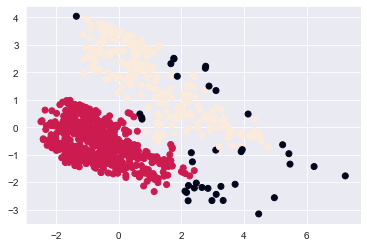

In [183]:
make_DBSCAN_2D(Etalon_no_SA_CA_oh_en_no_risk_scale_PCA, epsilon=0.466, min_sam=10)

# {'best_epsilon': 0.4663220338983051,
#  'best_min_samples': 10,
#  'best_score': 0.5345824020009975}

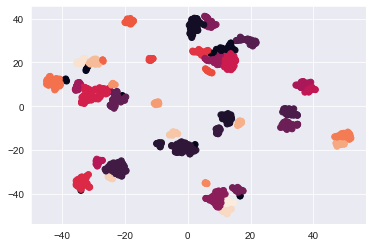

In [186]:
make_DBSCAN_2D(Etalon_no_SA_CA_oh_en_no_risk_scale_TSNE, epsilon=1.47, min_sam=5)

# {'best_epsilon': 1.4747457627118644,
#  'best_min_samples': 5,
#  'best_score': -0.03759503}

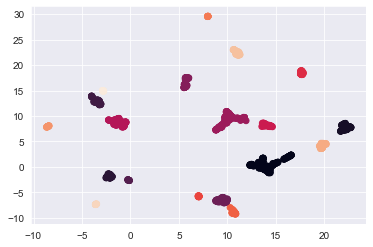

In [189]:
make_DBSCAN_2D(Etalon_no_SA_CA_oh_en_no_risk_scale_UMAP, epsilon=0.82, min_sam=4)

# {'best_epsilon': 0.8245762711864407,
#  'best_min_samples': 4,
#  'best_score': 0.7888886}

# 「 Dimensionality Reduction to 3D 」

In [42]:
Etalon_no_SA_CA_oh_en_no_risk_scale_TSNE_3 = make_TSNE(Etalon_no_SA_CA_oh_en_no_risk_scale, 3)
Etalon_no_SA_CA_oh_en_no_risk_scale_PCA_3  = make_PCA(Etalon_no_SA_CA_oh_en_no_risk_scale, 3)
Etalon_no_SA_CA_oh_en_no_risk_scale_UMAP_3 = make_UMAP(Etalon_no_SA_CA_oh_en_no_risk_scale, 3)

In [198]:
best_dict = get_scores_and_labels(combinations, Etalon_no_SA_CA_oh_en_no_risk_scale_UMAP_3)

In [199]:
best_dict

{'best_epsilon': 1.4096969696969697,
 'best_min_samples': 4,
 'best_labels': array([ 0,  1,  2,  3,  3,  2,  4,  5,  0,  6,  5,  7,  1,  8,  5,  1,  0,
         7,  3,  0,  6,  9,  5,  6,  4, 10,  0,  9,  0,  7,  7,  4,  6,  7,
        11,  0,  2,  0, 12,  0,  0,  0, 13,  5,  3,  6,  0,  5,  8,  1, 10,
         6,  0,  6,  3,  8,  0,  1,  6, 14,  7,  0,  7,  7,  1, 13,  1,  6,
         2,  1,  6,  9, 15,  7,  2,  3,  0,  0,  6,  4,  1,  0,  7, 15,  0,
         7, 11,  2,  6, 13,  0,  6,  1, 14,  6,  7,  2,  7,  0,  5,  5,  9,
         1, 14,  5, 15,  6,  6, 11,  7,  7,  2,  5,  6,  0,  0,  1, 14, 11,
         6,  1,  5, 14,  3, 14,  6,  0, 13,  6,  6,  6,  2, 10,  3,  1,  1,
         6,  0,  0,  9,  8,  1,  0,  4, 11,  7,  6,  6,  4,  0, 16,  0,  0,
         5,  7, 14, 13,  2,  6,  0,  0,  6, 12,  3,  6,  4, 11, 11, 14,  7,
         5, 11, 11,  0,  2,  6,  4,  0,  9,  6,  7,  7,  8,  4,  6,  0,  3,
         3,  0, 11,  7,  7,  7,  9,  9,  2,  1, 14,  3,  4,  2,  8,  7,  2,
         8, 

In [193]:
make_3D_plot_DBSCAN(Etalon_no_SA_CA_oh_en_no_risk_scale_PCA_3, epsilon=0.96, min_sam=15)
# {'best_epsilon': 0.9581818181818181,
#  'best_min_samples': 15,

In [200]:
make_3D_plot_DBSCAN(Etalon_no_SA_CA_oh_en_no_risk_scale_UMAP_3, epsilon=1.4, min_sam=4)
# 'best_epsilon': 1.4096969696969697,
# 'best_min_samples': 4,

In [203]:
make_3D_plot_DBSCAN(Etalon_no_SA_CA_oh_en_no_risk_scale_TSNE_3, epsilon=1.5, min_sam=4)
# 'best_epsilon': 1.5,
# 'best_min_samples': 4,

In [163]:
# эту функцию из лекции, я использовал для проверки
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i, min_samples = 4).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|██████████| 169/169 [00:04<00:00, 40.14it/s]


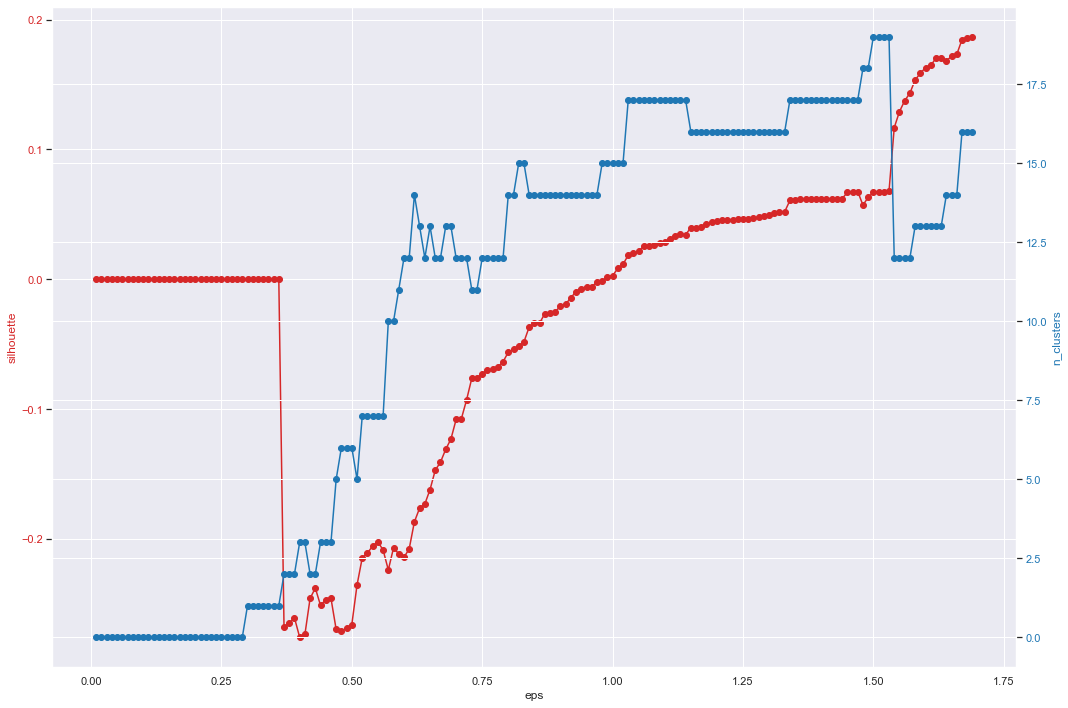

In [244]:
eps_range = np.arange(0.01,1.7,0.01)
dbscan_clustering(eps_range, Etalon_no_SA_CA_oh_en_no_risk_scale)

надо отметить, что этот датасет - из тех, что являются слабым местом у алгоритма DBSCAN и поэтому получены такие графики. при том, что я умышленно поставил минимальное количество точек в окрестности эпсилона.

# 「 Часть 3. Интерпретация. 」

In [238]:
dbscan = DBSCAN(eps = 1.5, min_samples = 4).fit(Etalon_no_SA_CA_oh_en_no_risk_scale)
db_labels = dbscan.labels_

In [239]:
inversed = make_scale(Etalon_no_SA_CA_oh_en_no_risk, inv=1)

In [240]:
Inversed_Etalon_df = pd.DataFrame(inversed, columns=Etalon_no_SA_CA_oh_en_no_risk.columns)
Inversed_Etalon_df['labels'] = db_labels

In [241]:
sns.set(rc={"figure.figsize":( 15, 10 )})

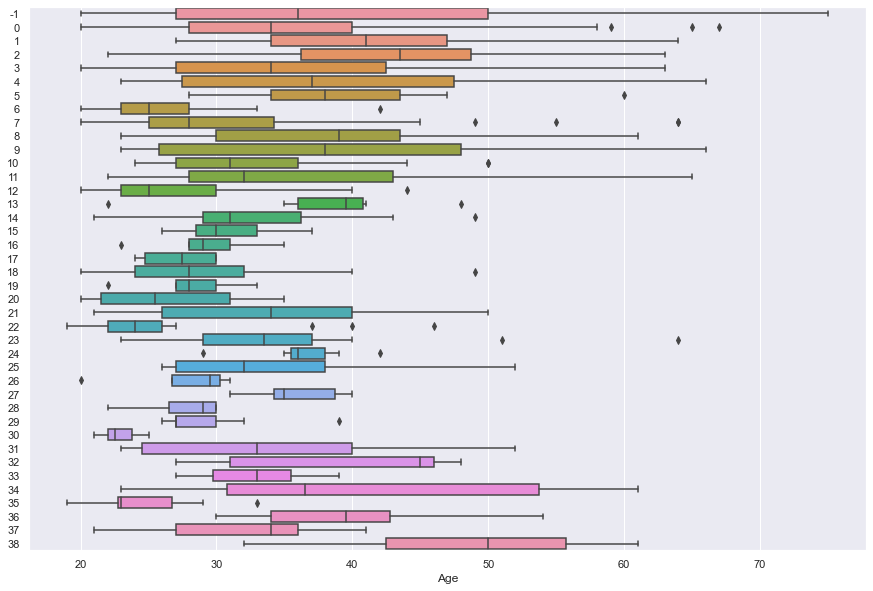

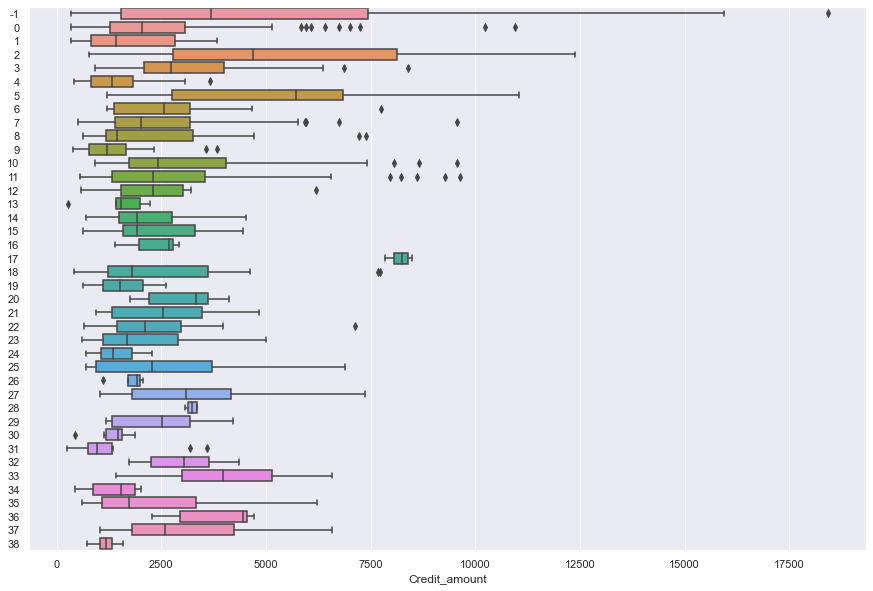

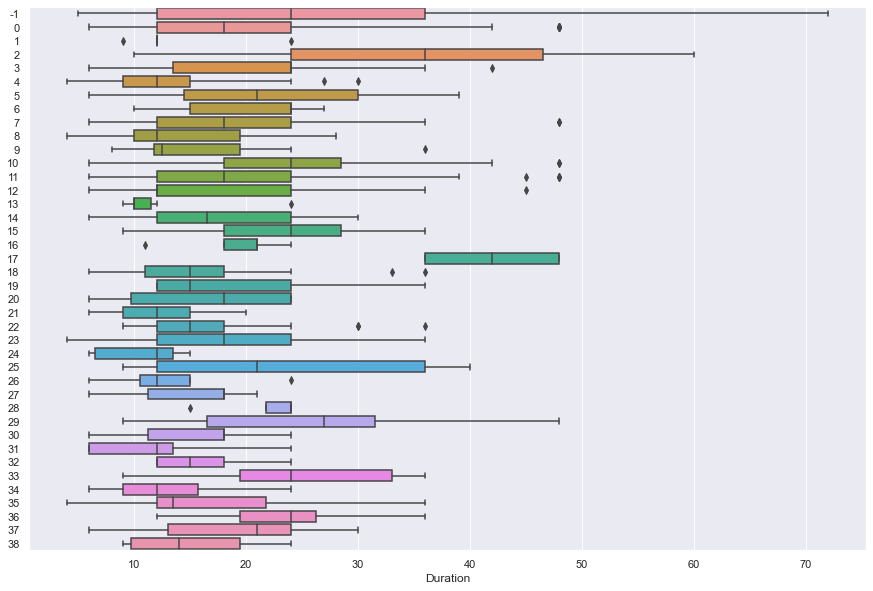

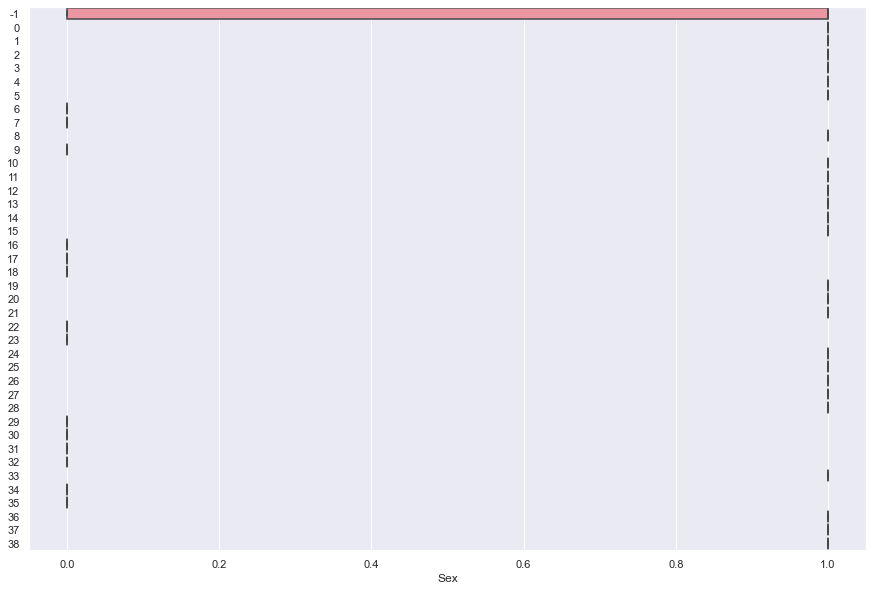

In [242]:
for col in Inversed_Etalon_df[['Age', 'Credit_amount', 'Duration', 'Sex']].columns:
    sns.boxplot(data=Inversed_Etalon_df, x=col, y=db_labels, orient='h')
    plt.show()

In [243]:
Inversed_Etalon_df[['Age', 'Credit_amount', 'Duration', 'Job', 'labels', 'Sex']].groupby('labels').mean().T.round(2)


labels,-1,0,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
Age,39.62,35.59,42.00,43.15,35.75,39.00,38.16,26.48,31.48,38.00,...,29.43,22.83,34.09,39.4,32.83,40.88,24.75,39.83,31.89,48.25
Credit_amount,5052.81,2540.05,1842.57,5322.58,3136.73,1476.16,5208.58,2658.33,2577.35,2257.44,...,2420.57,1319.00,1333.36,3006.0,4024.67,1376.25,2401.62,3821.83,3146.44,1174.75
Duration,26.29,20.86,13.29,32.42,21.20,12.61,22.58,19.95,19.29,13.54,...,25.71,15.50,11.45,16.2,24.50,12.88,17.00,23.50,19.11,15.25
Job,1.92,2.00,1.00,2.00,2.00,1.00,3.00,2.00,2.00,1.00,...,2.00,2.00,1.00,1.0,3.00,2.00,1.00,3.00,1.00,2.00
Sex,0.58,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.0,1.00,0.00,0.00,1.00,1.00,1.00


Как то проинтерпретировать разбиение на кластеры алгоритмом DBscan не представляется возможным. Количество кластеров во всех вариациях превышает 20, при целевых двух кластерах.
В этом случае можно сказать, что отрицательный результат говорит о том, что гипотеза о том, что эти данные можно разметить с помошью DBSCAN - ошибочна и использовать его не нужно и необходимо переключиться на другой алгоритм.

Как итог хочу отметить, что выполнение этого дз дало объёмное понимание в теме уменьшения размерности датасетов (зачем, какие виды бывают) и я углубился в тему кластеризации и обучения без учителя, где смог увидеть сильные и слабые стороны различных алгоритмов кластеризации.